<a href="https://colab.research.google.com/github/AlejandraMatajira/Mi-repositorio-/blob/main/ind2_alejandramatajira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computación Distribuida NLP
Maria Alejandra Matajira    ID:0000261938

## Descripción de la Base de Datos

Esta base de datos ha sido extraída del **corpus multilingüe de reseñas de Amazon** y contiene los siguientes parámetros:

- **`Review_id`**: Identificador único de la reseña.
- **`Product_id`**: Identificador único del producto.
- **`Reviewer_id`**: Identificador único del usuario que escribió la reseña.
- **`Review_body`**: Texto completo de la reseña.
- **`Review_title`**: Título de la reseña.
- **`Language`**: Idioma en el que está escrita la reseña.
- **`Product_category`**: Categoría del producto, como por ejemplo: electrónico, utensilios, etc.


## Análisis de NLP


In [ ]:

import gzip
import json
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk # imports the natural language toolkit
import pandas as pd
import plotly
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import json
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress
import dask.bag as db

nltk.download('punkt') ## Tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
client = Client(n_workers=2, threads_per_worker=4, processes=False, memory_limit='8GB')
client

c:\Users\aleja\.conda\envs\guia502\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50892 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.10.7:50892/status,
Dashboard: http://192.168.10.7:50892/status,Workers: 2
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: False
Comm: inproc://192.168.10.7/13028/39,Workers: 2
Dashboard: http://192.168.10.7:50892/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: inproc://192.168.10.7/13028/42,Total threads: 4
Dashboard: http://192.168.10.7:50896/status,Memory: 7.45 GiB
Nanny: None,


2024-09-04 13:22:48,792 - distributed.scheduler - WARNING - Worker failed to heartbeat for 878s; removing: <WorkerState 'inproc://192.168.10.7/13028/42', name: 0, status: running, memory: 0, processing: 0>
2024-09-04 13:22:48,814 - distributed.scheduler - WARNING - Worker failed to heartbeat for 878s; removing: <WorkerState 'inproc://192.168.10.7/13028/44', name: 1, status: running, memory: 0, processing: 0>
2024-09-04 13:22:48,817 - distributed.scheduler - WARNING - Workers ['inproc://192.168.10.7/13028/44', 'inproc://192.168.10.7/13028/42'] do not use a nanny and will be terminated without restarting them
2024-09-04 13:22:48,825 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'inproc://192.168.10.7/13028/44'.
2024-09-04 13:22:48,827 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'inproc://192.168.10.7/13028/42'.
2024-09-04 13:22:48,833 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.

## Procesamiento del conjunto de datos medinte la libreria DASK

In [ ]:
bag_video_dataset = db.read_text('dataset_es_dev.json', blocksize='10MB').map(json.loads)

In [ ]:
bag_video_dataset.count().compute()  # Count total number of records


5000

In [ ]:
bag_video_dataset.take(2)

({'review_id': 'es_0417480',
  'product_id': 'product_es_0873923',
  'reviewer_id': 'reviewer_es_0672978',
  'stars': '1',
  'review_body': 'Malisimo, muy grande demasiado aparatoso y mal protector de pantalla',
  'review_title': 'Mala compra',
  'language': 'es',
  'product_category': 'wireless'},
 {'review_id': 'es_0180432',
  'product_id': 'product_es_0713146',
  'reviewer_id': 'reviewer_es_0100858',
  'stars': '1',
  'review_body': 'No he recibido el pedido no la devolución',
  'review_title': 'No lo he recibido',
  'language': 'es',
  'product_category': 'apparel'})

In [ ]:
def flatten(record):
    return {
        'review_id': record['review_id'],
        'stars': record['stars'],
        'review_body': record['review_body'],
        'review_title': record['review_title'],
        'language': record['language'],
        'product_category': record['product_category']
    }

bag_video_dataset.map(flatten).take(1)

({'review_id': 'es_0417480',
  'stars': '1',
  'review_body': 'Malisimo, muy grande demasiado aparatoso y mal protector de pantalla',
  'review_title': 'Mala compra',
  'language': 'es',
  'product_category': 'wireless'},)

In [ ]:
df_final = bag_video_dataset.map(flatten).to_dataframe()
df_final["stars"] = df_final["stars"].astype(float)
df_final.head()

,review_id,stars,review_body,review_title,language,product_category
0,es_0417480,1.0,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,1.0,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,1.0,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,1.0,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,1.0,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [ ]:
bag_video_frecuencias = bag_video_dataset.map(lambda d: d['stars']).frequencies(sort=True).compute()
bag_video_frecuencias

[('1', 1000), ('2', 1000), ('3', 1000), ('4', 1000), ('5', 1000)]

#### Gráfica de pastel: porcentaje de calificaciones (estrellas)

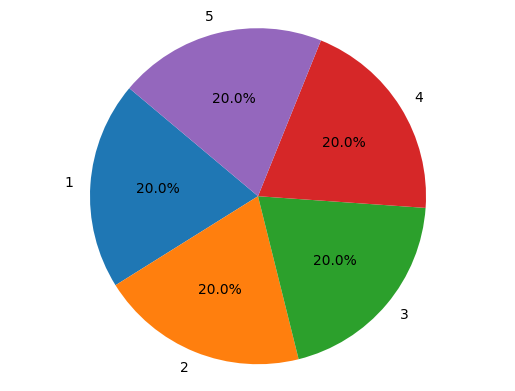

In [ ]:
def plot_pie(data_list):
    # Desempaquetar la lista en etiquetas y valores
    labels, sizes = zip(*data_list)

    # Crear la gráfica de pastel
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)


    plt.axis('equal')

    # Devolver el gráfico para su posterior uso
    return plt

# Ejemplo de uso
ax1 = plot_pie(bag_video_frecuencias)
ax1.show()

La gráfica de pastel muestra que la base de datos recopiló los datos de manera uniforme. Cada categoría de calificación del producto contiene aproximadamente 1,000 reseñas, lo que resulta en una distribución equitativa. Como consecuencia, las cinco categorías de calificación representan cada una el 20% del total.

In [ ]:
#loading libraries
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from functools import partial

In [ ]:
#First part, classify reviews as positive if the overall rating is > 3 and negative otherwise
def tag_positive_negative_by_score(element):
    if float(element['stars']) > 3:
        element['review_sentiment'] = 'positive'
    else:
        element['review_sentiment'] = 'negative'
    return element

In [ ]:
bag_video_dataset.map(tag_positive_negative_by_score).take(1)

({'review_id': 'es_0417480',
  'product_id': 'product_es_0873923',
  'reviewer_id': 'reviewer_es_0672978',
  'stars': '1',
  'review_body': 'Malisimo, muy grande demasiado aparatoso y mal protector de pantalla',
  'review_title': 'Mala compra',
  'language': 'es',
  'product_category': 'wireless',
  'review_sentiment': 'negative'},)

In [ ]:

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from functools import partial

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

tokenizer = RegexpTokenizer(r'\w+')

def extract_reviews(bagtoprocess):
    return bagtoprocess['review_body'].lower()

def checkif_stopword(word, stopwords):
    return word not in stopwords

def filter_stopwords(tokens, stopwords):
    return list(filter(partial(checkif_stopword, stopwords=stopwords), tokens))
stopword_set = set(stopwords.words('spanish'))

In [ ]:
reviews_text_iv = bag_video_dataset.map(extract_reviews) #all text in lower
reviews_txtokens_iv = reviews_text_iv.map(tokenizer.tokenize) #just words
reviews_txclean_iv = reviews_txtokens_iv.map(partial(filter_stopwords, stopwords=stopword_set))

In [ ]:
display(reviews_text_iv.take(1))
#reviews_text_tokens.take(1)
display(reviews_txclean_iv.take(1))

('malisimo, muy grande demasiado aparatoso y mal protector de pantalla',)

(['malisimo',
  'grande',
  'demasiado',
  'aparatoso',
  'mal',
  'protector',
  'pantalla'],)

In [ ]:
all_reviews_clean_iv = reviews_txclean_iv.flatten()
all_reviews_clean_iv.take(6)

('malisimo', 'grande', 'demasiado', 'aparatoso', 'mal', 'protector')

In [ ]:
def combine(total1, total2):
    return total1 + total2

def count(accumulator,element):
    return accumulator + 1

In [ ]:
all_reviews_products = bag_video_dataset.map(extract_reviews)
all_reviews_products_tokens = all_reviews_products.map(tokenizer.tokenize) #just words
all_reviews_products_clean = all_reviews_products_tokens.map(partial(filter_stopwords, stopwords=stopword_set)) #filtering english stopwords

In [ ]:
import dask.dataframe as dd
df_final['reviewlen'] = df_final['review_body'].str.len()


In [ ]:
max_reviewlen = df_final["reviewlen"].max().compute()

# Imprime el valor calculado
print(max_reviewlen)

1576


### Gráfica Distribución de la Longitud de las Reseñas

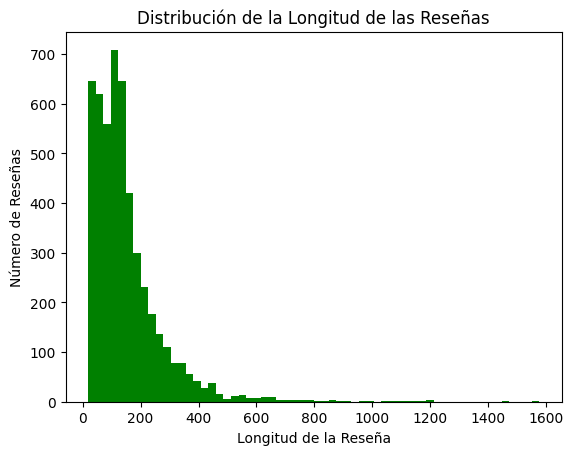

In [ ]:

# Convierte la columna 'reviewlen' a un pandas DataFrame
reviewlen_pandas = df_final["reviewlen"].compute()

# Crea el histograma
plt.hist(reviewlen_pandas, color="green", bins=60)

# Agrega título y etiquetas a los ejes
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud de la Reseña')
plt.ylabel('Número de Reseñas')

# Desactiva la cuadrícula
plt.grid(False)

# Muestra el gráfico
plt.show()

La gran mayoría de las reseñas son relativamente cortas, concentrándose en las primeras barras del histograma, por lo que, sugiere que la mayoría de los usuarios prefieren dejar comentarios concisos. Tambien se logra observar una disminución gradual, ya que, a medida que aumenta la longitud de las reseñas, el número de ellas disminuye de manera gradual. Esto indica que a medida que las reseñas se hacen más largas, son menos frecuentes. Por ultimo, una existe muy pocas reseñas que superan las 1000 palabras, esto se podria deber a varios factores, como la disposición de los usuarios a dedicar mucho tiempo a escribir una reseña detallada, o las limitaciones de las plataformas para reseñas muy extensas.

## Bigramas

In [ ]:
def make_bigrams(tokens):
    return set(nltk.bigrams(tokens))

In [ ]:
review_bigrams1 = all_reviews_products_clean.map(make_bigrams)
all_bigrams = review_bigrams1.flatten()

In [ ]:
top10_bigrams = all_bigrams.foldby(lambda x: x, count, 0, combine, 0).topk(10, key=lambda x: x[1]).compute()
top10_bigrams

[(('calidad', 'precio'), 192),
 (('buena', 'calidad'), 157),
 (('relación', 'calidad'), 94),
 (('funciona', 'bien'), 85),
 (('buen', 'producto'), 70),
 (('va', 'bien'), 67),
 (('mala', 'calidad'), 50),
 (('cumple', 'función'), 47),
 (('bastante', 'bien'), 46),
 (('queda', 'bien'), 41)]

### Conclusiones del Análisis de Bigramas
los bigramas más frecuentes sugieren que los usuarios tienden a centrar sus opiniones en la calidad, el precio, y el buen funcionamiento de los productos. Estos aspectos parecen ser determinantes en la percepción general y en la satisfacción del cliente con los productos analizados teniendo en cuenta que los aspectos que más se comentaron fueron:

- **Relación Calidad-Precio:** El bigrama más frecuente, "calidad precio", con 192 apariciones, sugiere que la relación entre la calidad del producto y su precio es un tema crucial para los consumidores. Esto indica que los usuarios valoran especialmente productos que ofrezcan un buen balance entre estos dos factores.

- **Calidad del Producto:** "Buena calidad" y "mala calidad" son otros bigramas destacados, con 157 y 50 menciones, respectivamente. Esto subraya que la calidad es un aspecto central en la experiencia del cliente, siendo un factor decisivo en la satisfacción o insatisfacción con el producto.

- **Funcionamiento:** Bigrams como "funciona bien" (85 menciones) y "cumple función" (47 menciones) indican que los usuarios también valoran que el producto cumpla con sus expectativas en términos de funcionalidad. La repetición de términos como "bien" en contextos de funcionamiento sugiere una evaluación positiva general de los productos analizados.

- **Opiniones Positivas Generales:** Bigrams como "buen producto" (70 menciones) y "bastante bien" (46 menciones) destacan la tendencia de los usuarios a emitir juicios generales positivos sobre los productos, lo cual podría indicar un nivel alto de satisfacción en la mayoría de los casos.

- **Ajuste y Compatibilidad:** El bigrama "queda bien" (41 menciones) sugiere que la adecuación o el ajuste de los productos es también un tema importante para los usuarios, lo cual podría ser relevante para categorías de productos como ropa, accesorios o piezas que deben encajar correctamente.

###  ¿Cuáles son las palabras mas comunes que se presentan en el sentimiento negativo que no están en el positivo?
---



Debido a la falta de una librería estándar que proporcione stopwords en español, se optó por descargar un archivo específico para obtener un listado completo de stopwords en este idioma. El archivo adjunto, "spanish-stop-words.txt", contiene más de 300 stopwords en español, asegurando así una cobertura amplia y precisa para los análisis de texto. Este enfoque permite realizar una limpieza de datos más efectiva y adaptada al idioma, mejorando la calidad de los resultados en el procesamiento de texto.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()
    return stopwords

def get_top_n_words(corpus, n=1, k=1, stopwords_file='spanish-stop-words.txt'):
    # Cargar las stopwords desde el archivo
    stopwords = load_stopwords(stopwords_file)

    vec = CountVectorizer(ngram_range=(k, k), stop_words=stopwords)
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(new_words, sum_words[0, idx]) for new_words, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df_final["review_body"], n=20, k=1, stopwords_file='spanish-stop-words.txt')

En primer lugar, se optuvo la gráfica distribución de frecuencia de las palabras más comunes en la reseñas, en las que abarca tanto los sentimientos postivos y negativos.

<Axes: title={'center': 'Top 20 palabras más repetidas en las reseñas'}, xlabel='words'>

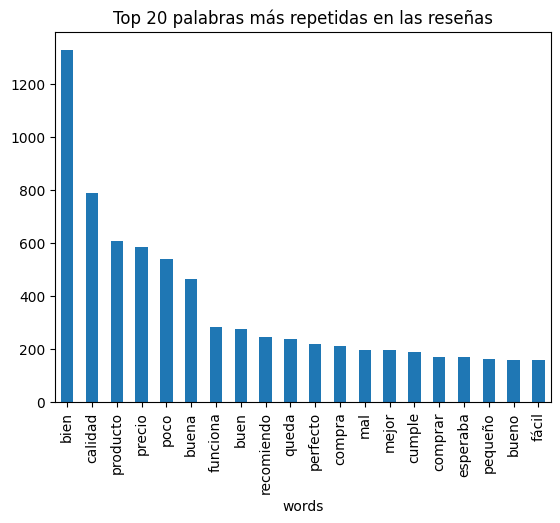

In [ ]:
df_top_words = pd.DataFrame(common_words, columns=["words", "count"])
df_top_words.groupby("words").sum()["count"].sort_values(ascending=False).plot(
    kind="bar", title="Top 20 palabras más repetidas en las reseñas"
)

Posteriormente, se filtró la base de datos de manera que aquellas reseñas que tuvieron una calificación mayor a 3, se le categorizara como sentimiento **Positivo** y aquellas que tuvieran una calificación menor a 3 un sentimiento **Negativo**.

In [ ]:
good_indices = df_final["stars"] > 3
good_reviews = df_final[good_indices]
bad_indices = df_final["stars"] < 3
bad_reviews = df_final[bad_indices]

In [ ]:
common_wordsP = get_top_n_words(good_reviews["review_body"], 20)
common_wordsB = get_top_n_words(bad_reviews["review_body"], 20)

Adicionalmente, siendo que lo que se pide son las palabra más comunes que se encuentran en el sentimiento **Negativo** que no estan en el Positivo, se realizó un filtro de manera que si las palabras tanto de positivo y negativo coincidian no se tomaran en cuenta en la gráfica.

In [ ]:
# Convertir a conjuntos de palabras para encontrar intersección
words_good_set = set(word for word, _ in common_wordsP)
words_bad_set = set(word for word, _ in common_wordsB)

# Encontrar las palabras comunes
common_words_to_remove = words_good_set.intersection(words_bad_set)

# Filtrar las palabras comunes de las listas originales
filtered_good_words = [item for item in common_wordsP if item[0] not in common_words_to_remove]
filtered_bad_words = [item for item in common_wordsB if item[0] not in common_words_to_remove]

#### Gráfica de top 10 palabras más frecuentes en las reseñas de sentimiento positivo

<Axes: title={'center': 'Top 10 words from good reviews'}, xlabel='words'>

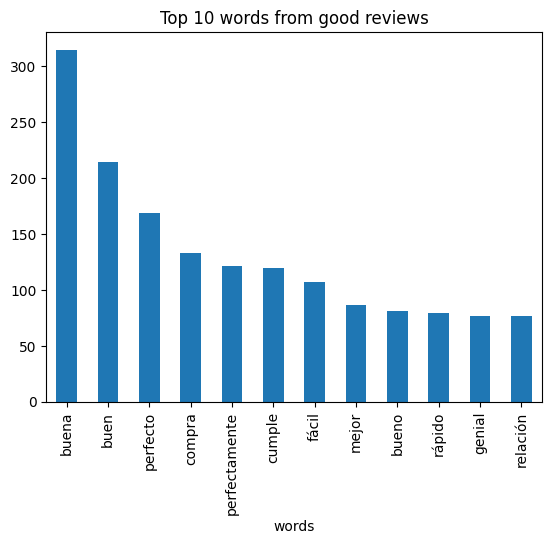

In [ ]:
df_positive = pd.DataFrame(filtered_good_words, columns=["words", 'count'])
df_positive.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 10 words from good reviews'
)

La gráfica tiene como palabras con mayor frecuencia aquellas que tienen una connotación negativa cómo: "buena", "buen", "perfecto", "perfectamente", "mejor", "bueno", que puede estar relacionado tanto con el producto como el servicio, mientras que palabras como: "facil", "compra", "relación" puede estar más relacionado al servicio.

### Gráfica de top 10 palabras más frecuentes en las reseñas de sentimiento Negativo

<Axes: title={'center': 'Top 10 words from bad reviews'}, xlabel='words'>

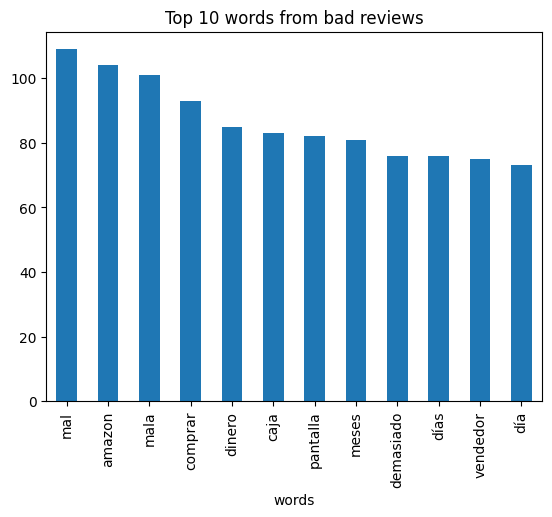

In [ ]:
df_negative = pd.DataFrame(filtered_bad_words, columns=['words', 'count'])
df_negative.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 10 words from bad reviews'
)

### **Respuesta:**
Como es de esperar, las palabras con mayor frecuencia tienen una connotación negativa: "mal", "mala", "demasiado". Esto confirma que el análisis se centra en reseñas expresando insatisfacción.
Por otro lado, la palabra "amazon" aparece prominentemente, lo que sugiere que las reseñas analizadas provienen en su mayoría de esta plataforma de comercio electrónico. Ahora bien, términos como "pantalla", "caja" y "días" podrían indicar problemas relacionados con el producto en sí, su empaquetado o el tiempo de entrega. y por ultimo, palabras como "comprar", "dinero" y "vendedor" sugieren que los usuarios están expresando insatisfacción con el proceso de compra o con la atención al cliente.

###  ¿Qué diferencias encontró en la capacidad de la librería NLTK para analizar idioma español vs inglés?
---

### Recursos Disponibles
Las principales diferencias que se encontraron en la capacidad de la libreria NLTK para análizar idioma español vs inglés fue las evidentes limitaciones de NLTK para el Español, puesto que los modelos pre-entrenados para español pueden no alcanzar la misma precisión que los modelos para inglés, especialmente en tareas que requieren una comprensión profunda del lenguaje, como la traducción automática o el análisis de sentimientos. Esto se puede deber a las sigueintes razones:

1. **Recursos Lingüísticos:** Cómo se mencionó anteriormente la disponibilidad y calidad de los corpora anotados para el español pueden ser menores en comparación con el inglés. Esto afecta directamente el entrenamiento de modelos y la precisión de los resultados,y aunque NLTK ofrece algunos modelos pre-entrenados para español, su cobertura y precisión pueden no ser tan altas como las de los modelos para inglés, que son más numerosos y refinados.

2. **Complejidad Gramatical:** El español es una lengua altamente flexionada, con una gran cantidad de formas verbales y nominales que varían según el género, número, tiempo y modo. Esto puede complicar tareas como la lematización y el etiquetado POS. Además, el orden de las palabras en español es más flexible que en inglés, lo que puede dificultar el análisis sintáctico y por ende la capacidad de la libreria NLTK no tiene tan reforzado esta complejidad gramatical.

3. **Variedad dialectal:** El español presenta una gran variedad dialectal, con diferencias significativas en vocabulario, gramática y pronunciación. Esto puede dificultar la creación de modelos lingüísticos generales que funcionen bien en todos los dialectos.

### Stopwords
Por otro lado se encontró que el soporte para stopwords en español en NLTK es menos robusto, y a pesar de que la libreria NLTK incluye un conjunto básico de stopwords en español, puede que no sea tan exhaustivo como el conjunto en inglés. Por lo tanto, a menudo es necesario recurrir a listas personalizadas. Por esta razón es que a la hora importar stopwords en el idioma de español se obtuvo un listado descargado de una fuentes de internet "spanish-stop-words.txt". obtenido de: https://gist.github.com/cr0wg4n/78554c5d0afa9944d2fa3a4435d83a57.

In [ ]:

data = pd.read_csv("spanish-stop-words.txt")
print(data.head(5))

             a
0  actualmente
1     adelante
2       además
3       afirmó
4       agregó


### Encontrar bases de datos

Se observó como en el idioma Inglés NLTK incluye una amplia gama de corpus y datos lingüísticos en inglés, como el corpus de películas, siendo estos datos bien documentados y extensos. Mientras que en Español Los corpus disponibles para el español en NLTK son menos variados y extensos. Puede que se necesiten recursos externos o personalizados para obtener datos lingüísticos completos para análisis en español.

### Preprocesamiento de texto

Las funciones de preprocesamiento en NLTK están bien adaptadas para el inglés, manejando aspectos como la tokenización, la normalización y la eliminación de puntuación de manera efectiva.
No obstante, en Español aunque NLTK ofrece herramientas básicas para el preprocesamiento en español, las diferencias gramaticales y ortográficas del español pueden requerir ajustes adicionales en el procesamiento de texto para obtener resultados óptimos.

### Estrategias para lograr procesar el conjunto de datos

---

#### Workers

Para identificar la cantidad de workers se optó por mirar la capacidad de núcleos de CPU disponibles en mi computadora. Para ello entré en Administrador de tarea -> Rendimiento y actualmente cuento con 8 núcleos, tambien lo verifiqué utilizando el código cpu_count():

In [ ]:
from dask.distributed import Client, LocalCluster
import os
# Verifica el número de núcleos de CPU disponibles
num_cpus = os.cpu_count()
num_cpus

8


Dado que mi máquina cuenta con 8 núcleos, he decidido configurar un número de workers menor para dejar algo de capacidad disponible para otras tareas del sistema. La base de datos con la que estoy trabajando no es muy pesada, por lo que opté por utilizar 2 workers, lo que debería ser suficiente para manejar la carga sin saturar los recursos.

#### Configuración de Threads por Worker

Cada worker puede manejar múltiples tareas simultáneamente utilizando hilos de ejecución (threads). Para esta configuración, he decidido utilizar `threads_per_worker=4`, lo que permitirá que cada worker gestione varias operaciones de I/O al mismo tiempo. Esta configuración es especialmente útil dado que las tareas que estoy ejecutando son más orientadas a I/O, beneficiándose del paralelismo que ofrecen los threads.

#### Uso de `processes=False`

Debido a la naturaleza ligera de las tareas y el tamaño manejable de la base de datos, he optado por establecer `processes=False`. Esto significa que los workers se ejecutarán como hilos dentro de un solo proceso, lo que ayuda a reducir la sobrecarga de memoria y es una buena opción para operaciones menos intensivas en CPU.

#### Límite de Memoria (`memory_limit`)

Dado que estoy trabajando con 2 workers y tengo 16 GB de RAM disponibles, cada worker puede utilizar hasta 8 GB de memoria. Esto se logra dividiendo la memoria total entre el número de workers, lo que asegura que cada worker tenga suficiente espacio para operar eficientemente sin agotar los recursos del sistema.

```python
client = Client(n_workers=2, threads_per_worker=4, processes=False, memory_limit='8GB')
client
